# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.utils import resample
from sklearn.metrics import adjusted_rand_score


import warnings
warnings.filterwarnings("ignore")

# Loading Dataset

In [2]:
# This data contains the details about consumers who purchased an EV
data = pd.read_csv("/content/sample_data/behavioural_dataset.csv")
data.head()

,Age,Profession,Marrital Status,Education,No of Dependents,Personal loan,House Loan,Wife Working,Salary,Wife Salary,Total Salary,Make,Price
0,27,Salaried,Single,Post Graduate,0,Yes,No,No,800000,0,800000,i20,800000
1,35,Salaried,Married,Post Graduate,2,Yes,Yes,Yes,1400000,600000,2000000,Ciaz,1000000
2,45,Business,Married,Graduate,4,Yes,Yes,No,1800000,0,1800000,Duster,1200000
3,41,Business,Single,Post Graduate,3,No,Yes,Yes,1600000,0,2200000,City,1200000
4,31,Salaried,Married,Post Graduate,2,Yes,No,Yes,1800000,800000,2600000,SUV,1600000


# Exploring Dataset

In [3]:
data.shape

(100, 13)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               100 non-null    int64 
 1   Profession        100 non-null    object
 2   Marrital Status   100 non-null    object
 3   Education         100 non-null    object
 4   No of Dependents  100 non-null    int64 
 5   Personal loan     100 non-null    object
 6   House Loan        100 non-null    object
 7   Wife Working      100 non-null    object
 8   Salary            100 non-null    int64 
 9   Wife Salary       100 non-null    int64 
 10  Total Salary      100 non-null    int64 
 11  Make              100 non-null    object
 12  Price             100 non-null    int64 
dtypes: int64(6), object(7)
memory usage: 10.3+ KB


In [5]:
for col in data.select_dtypes(include=['object']).columns:
  print(f"Unique values in column '{col}': {data[col].unique()}")


Unique values in column 'Profession': ['Salaried' 'Business']
Unique values in column 'Marrital Status': ['Single' 'Married']
Unique values in column 'Education': ['Post Graduate' 'Graduate']
Unique values in column 'Personal loan': ['Yes' 'No']
Unique values in column 'House Loan': ['No' 'Yes']
Unique values in column 'Wife Working': ['No' 'Yes' 'm']
Unique values in column 'Make': ['i20' 'Ciaz' 'Duster' 'City' 'SUV' 'Baleno' 'Verna' 'Luxuray' 'Creata']


# Data Cleaning

In [6]:
any_null = data.isnull().values.any()
print("Are there any null values in the DataFrame? ", any_null)

Are there any null values in the DataFrame?  False


In [7]:
data.duplicated().sum()

0

There are no null or duplicate values in the dataset

In [8]:
# There is an unknown value 'm' in 'Wife Working' column - Converting it to Yes

data['Wife Working'] = data['Wife Working'].replace('m', 'Yes')


In [9]:
data['Wife Working'].unique()

array(['No', 'Yes'], dtype=object)

# Exploratory Data Analysis

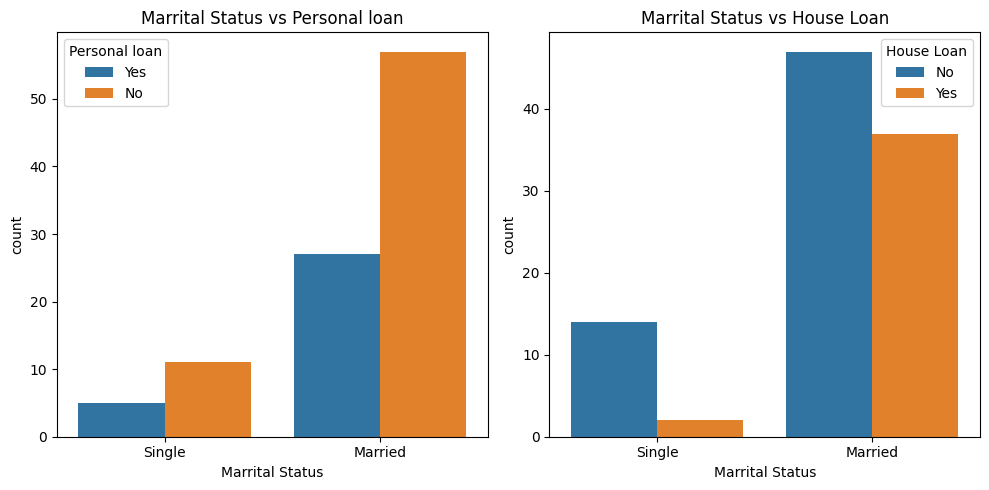

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Count plot for 'Marrital Status' vs count with 'Personal loan'
sns.countplot(x='Marrital Status', hue='Personal loan', data=data, ax=axes[0])
axes[0].set_title('Marrital Status vs Personal loan')

# Count plot for 'Marrital Status' vs count with 'House Loan'
sns.countplot(x='Marrital Status', hue='House Loan', data=data, ax=axes[1])
axes[1].set_title('Marrital Status vs House Loan')

plt.tight_layout()
plt.show()


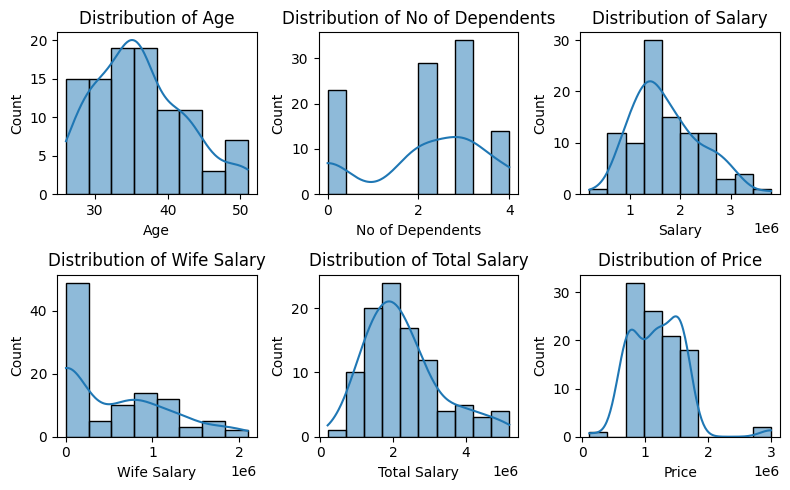

In [11]:
# Select numerical columns
numerical_cols = ['Age', 'No of Dependents', 'Salary', 'Wife Salary', 'Total Salary', 'Price']

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(8, 5))

# Plot univariate distributions
for i, col in enumerate(numerical_cols):
    row = i // 3
    col_num = i % 3
    sns.histplot(data[col], kde=True, ax=axes[row, col_num])
    axes[row, col_num].set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show() # Display the plot grid


# Observations from the graphs:

*   Age: The distribution of age appears to be roughly normally distributed, with the majority of buyers between the ages of 30 and 50.

*   No of Dependents: Most buyers have 0-2 dependents, with the number of buyers decreasing as the number of dependents increases.

*   Salary, Wife Salary, Total Salary: These distributions are right-skewed, indicating a higher concentration of individuals with lower incomes and a smaller number of individuals with very high incomes.

*   Price: The distribution of EV prices is also right-skewed, suggesting that most EVs purchased are in the lower to mid-price range.






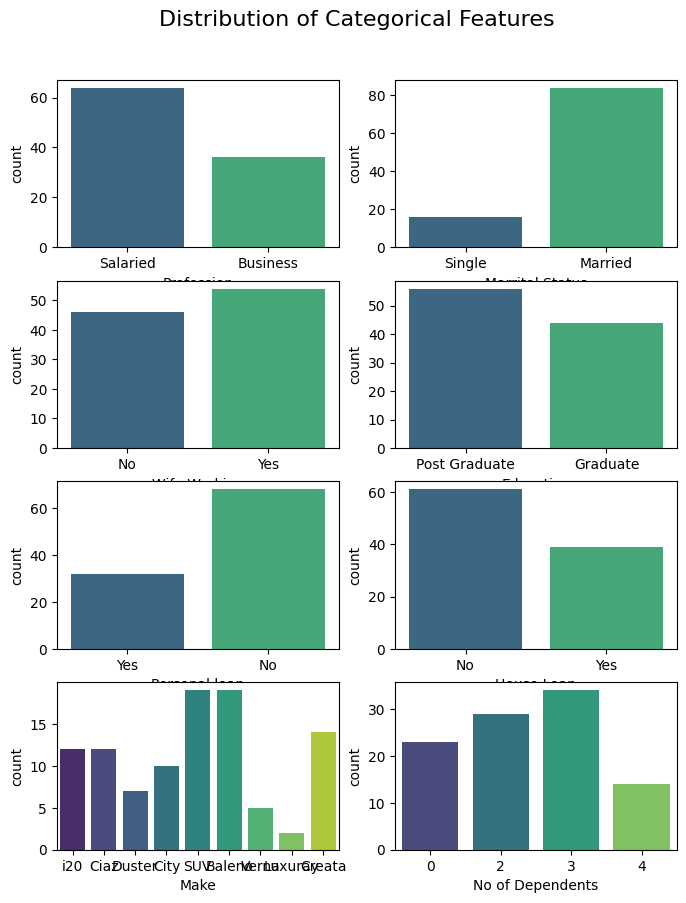

In [12]:
# Select categorical columns
categorical_cols = ['Profession', 'Marrital Status', 'Wife Working' ,'Education', 'Personal loan','House Loan', 'Make','No of Dependents']

# Create subplots
fig, axs = plt.subplots(4, 2, figsize=(8, 10))
for i, ax in enumerate(axs.flatten()):
    sns.countplot(data=data, x=categorical_cols[i], ax=ax, palette='viridis')
plt.suptitle("Distribution of Categorical Features", y=0.95, size='16')
plt.show()

# Key Findings

*   Approximately 65% of the customer base is employed in salaried positions, while 35% are self-employed.
*   Approximately 15% of the customers are single, while the remaining 85% are married.
*   A majority of customers have working spouses which is around 51%
*   Approximately 55% customers hold a Post Graduate degree while 35% have a Graduate degree.
*   Approximately 32% of the customers have a personal loan.
*   Approximately 38% of the customers have a house loan.
*   The most popular vehicle purchases among customers are SUVs and Balenos followed by Cretas.
*   Most of the customers have 2 to 3 dependents


# Data Preprocessing


In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [14]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder

# Initialize the LabelEncoder
encoder = LabelEncoder()

# Apply LabelEncoder to each categorical column in the DataFrame
df_encoded = data.copy()  # Make a copy of the original DataFrame to preserve it
for column in df_encoded.select_dtypes(include=['object', 'category']).columns:
    df_encoded[column] = encoder.fit_transform(df_encoded[column])

# Now df_encoded contains the encoded values
df_encoded.head()

,Age,Profession,Marrital Status,Education,No of Dependents,Personal loan,House Loan,Wife Working,Salary,Wife Salary,Total Salary,Make,Price
0,27,1,1,1,0,1,0,0,800000,0,800000,8,800000
1,35,1,0,1,2,1,1,1,1400000,600000,2000000,1,1000000
2,45,0,0,0,4,1,1,0,1800000,0,1800000,4,1200000
3,41,0,1,1,3,0,1,1,1600000,0,2200000,2,1200000
4,31,1,0,1,2,1,0,1,1800000,800000,2600000,6,1600000


*   For K-means clustering, features with a larger range of values can disproportionately influence the results.
*   We should select features that have a significant impact on the clustering and exhibit a wide range of values for scaling.
*   These features have a broader range compared to binary or categorical features and are likely to play a crucial role in determining cluster assignments.

In [15]:
# feature scaling
df_scaled = df_encoded.copy()
scaler = StandardScaler()
scaling_feature = ["Age", "No of Dependents", "Salary", "Wife Salary", "Total Salary", "Price"]
df_scaled[scaling_feature]  = scaler.fit_transform(df_scaled[scaling_feature])

In [16]:
df_scaled.shape

(100, 13)

### Elbow method indicates 3 clusters are optimal for the K-means algorithm.

In [17]:
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_scaled['Cluster'] = kmeans.fit_predict(df_scaled)

In [18]:
df_scaled.shape

(100, 14)

In [19]:
pca = PCA()
MD_pca = pca.fit_transform(df_scaled)
MD_p=pca.fit(df_scaled)

In [20]:
SD = np.sqrt(pca.explained_variance_)
EV = pca.explained_variance_ratio_  # tells how much of the total variance is captured by each principal component.
CEV = EV.cumsum() # cumulative_explained_variance Helps determine the number of components to retain to capture the desired amount of total variance.

summary_df = pd.DataFrame({
    'Standard deviation' : SD, 'Proportion of Variance': EV, 'Cumulative Proportion': CEV}).T.round(4)

summary_df.columns = [f'PC{i}' for i in range(1, pca.n_components_ + 1)]
print("\nSummary DataFrame:")
summary_df


Summary DataFrame:


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14
Standard deviation,2.9419,1.8168,1.1483,0.8608,0.6746,0.5738,0.5142,0.4386,0.4252,0.3371,0.2767,0.2424,0.2111,0.0338
Proportion of Variance,0.5501,0.2098,0.0838,0.0471,0.0289,0.0209,0.0168,0.0122,0.0115,0.0072,0.0049,0.0037,0.0028,0.0001
Cumulative Proportion,0.5501,0.7600,0.8438,0.8909,0.9198,0.9407,0.9575,0.9698,0.9813,0.9885,0.9934,0.9971,0.9999,1.0000


In [21]:
print("Standard Deviation:\n",SD.round(1))

Standard Deviation:
 [2.9 1.8 1.1 0.9 0.7 0.6 0.5 0.4 0.4 0.3 0.3 0.2 0.2 0. ]


In [22]:

# Get the loadings (components)
load = pca.components_

In [23]:

rot_matrix = MD_p.components_.T

# Create DataFrame for loadings
loadings_df = pd.DataFrame(-rot_matrix,
                           columns=[f'PC{i}' for i in range(1, MD_p.n_components_ + 1)],
                           index=df_scaled.columns.values)

# Print the loadings DataFrame rounded to 1 decimal place
loadings_df.round(3)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14
Age,-0.041,-0.424,-0.392,-0.105,-0.186,-0.652,0.145,-0.377,-0.122,-0.034,0.001,0.116,-0.041,0.012
Profession,-0.001,-0.050,0.062,-0.062,0.221,0.303,0.408,-0.169,-0.788,-0.048,-0.025,0.153,0.074,-0.017
Marrital Status,0.014,0.100,0.095,-0.177,-0.074,0.100,0.011,-0.064,0.160,-0.055,0.425,0.777,-0.334,0.071
Education,-0.020,-0.019,-0.018,-0.071,0.030,0.113,0.852,0.003,0.482,-0.049,-0.097,-0.099,-0.034,0.009
No of Dependents,-0.009,-0.258,-0.617,0.529,-0.183,0.395,0.002,0.239,-0.005,-0.051,0.100,0.110,-0.029,0.007
Personal loan,0.025,0.020,-0.153,-0.016,0.361,0.186,-0.163,-0.497,0.165,-0.608,0.283,-0.243,0.008,-0.019
House Loan,0.009,-0.045,-0.170,0.056,0.405,0.198,-0.130,-0.460,0.214,0.628,-0.246,0.173,0.056,0.019
Wife Working,-0.044,-0.094,0.213,0.361,0.141,-0.083,0.016,-0.065,-0.088,0.005,-0.148,-0.183,-0.845,0.078
Salary,-0.100,-0.433,-0.134,-0.541,0.245,0.163,-0.124,0.332,0.011,0.002,-0.030,-0.109,-0.141,0.496
Wife Salary,-0.135,-0.344,0.436,0.476,0.216,-0.170,0.041,0.022,0.093,-0.085,0.127,0.176,0.377,0.405


In [24]:
# Scale data before applying PCA
scaling=StandardScaler()

# Use fit and transform method
scaling.fit(df_scaled)
Scaled_data=scaling.transform(df_scaled)

# Apply PCA with the chosen number of components
# Choose the number of components based on the explained variance or scree plot
principal=PCA(n_components=3)
principal.fit(Scaled_data)
x=principal.transform(Scaled_data)

# Check the dimensions of data after PCA
print(x.shape)

(100, 3)


In [25]:
# Check the values of eigen vectors
# prodeced by principal components
principal.components_

array([[ 0.32027058,  0.10036699, -0.2772018 ,  0.05865353,  0.19538238,
        -0.08811364,  0.05628956,  0.27152236,  0.36071547,  0.3936223 ,
         0.4578762 ,  0.18966124,  0.36234395, -0.14923688],
       [ 0.30883664,  0.04421753, -0.25929789, -0.02469318,  0.39624812,
         0.36044842,  0.41051986, -0.1873954 ,  0.16706963, -0.18016227,
         0.00495142, -0.36322911, -0.17155253,  0.3499707 ],
       [ 0.02687336, -0.13153882,  0.00151505,  0.10536993,  0.14491291,
         0.31284197,  0.26495616, -0.24387893,  0.08375249, -0.20731248,
        -0.06733014,  0.54447432, -0.16354294, -0.58702369]])

## Plot the components (Visualization)

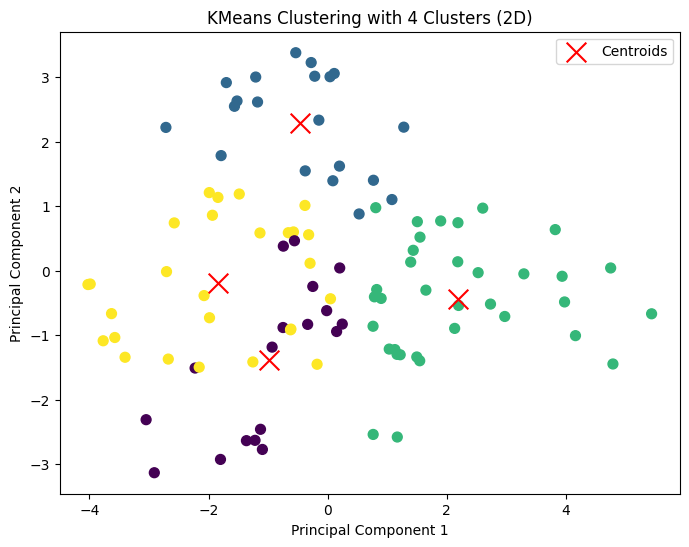

In [26]:

# Apply KMeans with 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42).fit(x)
labels = kmeans.labels_
data['Cluster'] = labels
df_encoded['Cluster'] = labels
clusters = kmeans.fit_predict(x)

# Get the cluster centroids
centroids = kmeans.cluster_centers_

# Plot the clusters and centroids
plt.figure(figsize=(8, 6))
plt.scatter(x[:, 0], x[:, 1], c=clusters, s=50, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=200, label='Centroids')
plt.title('KMeans Clustering with 4 Clusters (2D)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


# Extracting Segments


To illustrate a range of extraction techniques, we subdivide this step into 3 sections:

1. standard k-means analysis
2. finite mixtures of binary distributions
3. finite mixtures of regressions.

## Using K-Means

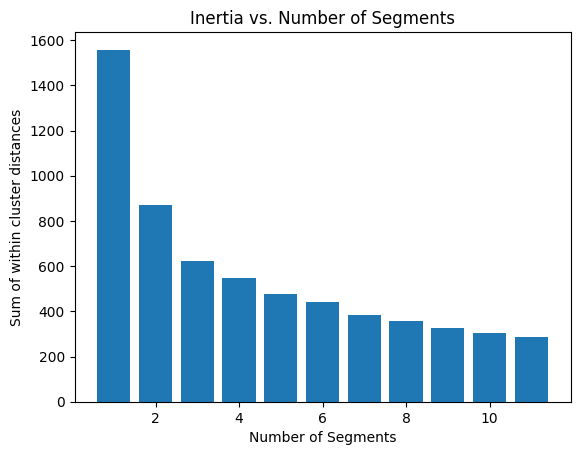

In [28]:

WCSS =[]

# Dictionary to store k-means models for each k
kmeans_data = {}

# Perform k-means clustering for 2 to 8 segments with 10 random restarts
for k in range(1, 12):
    # Initialize the k-means model
    kmeans = KMeans(n_clusters= k, n_init=10, random_state=42)

    # Apply the k-means algorithm to the data df_scaled
    kmeans.fit(df_scaled)

    # Append the inertia (within-cluster sum of squares) to the list
    WCSS.append(kmeans.inertia_)

    # Store the fitted model in the dictionary with the number of clusters as the key.
    kmeans_data[str(k)] = kmeans


# Plot the inertia values
plt.bar(range(1, 12), WCSS)
plt.xlabel('Number of Segments')
plt.ylabel('Sum of within cluster distances')
plt.title('Inertia vs. Number of Segments')
plt.show()

### The graph indicates that three clusters are optimal for the K-means algorithm.

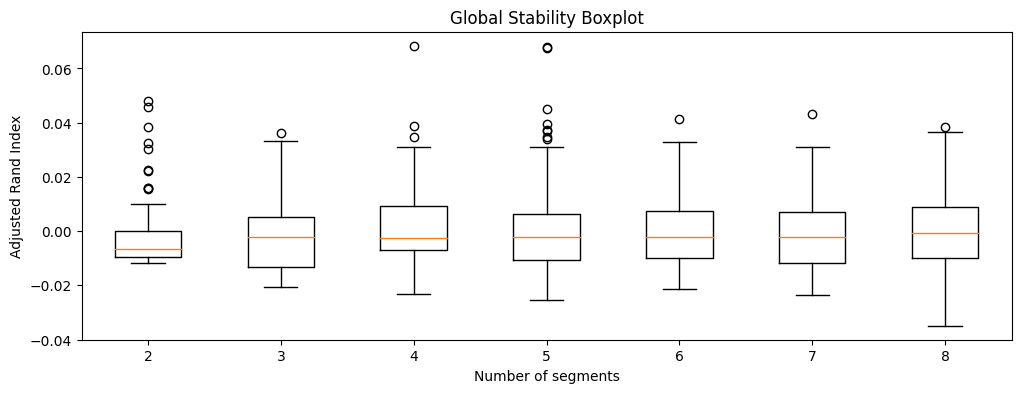

In [29]:

def bootstrap_stability(data, n_clusters, n_boot=100, n_rep=10):
    stability_scores = []

    for _ in range(n_boot):
        sample = resample(data)
        model = KMeans(n_clusters=n_clusters, n_init=n_rep, random_state=1234)
        model.fit(sample)
        labels = model.predict(data)
        stability = adjusted_rand_score(model.labels_, labels)
        stability_scores.append(stability)

    return stability_scores


n_segments = range(2, 9)
stability_results = {k: bootstrap_stability(df_scaled, k) for k in n_segments}


fig, ax = plt.subplots(figsize=(12,4))
ax.boxplot([stability_results[k] for k in n_segments], labels=n_segments)
ax.set_xlabel('Number of segments')
ax.set_ylabel('Adjusted Rand Index')
ax.set_title('Global Stability Boxplot')
plt.show()

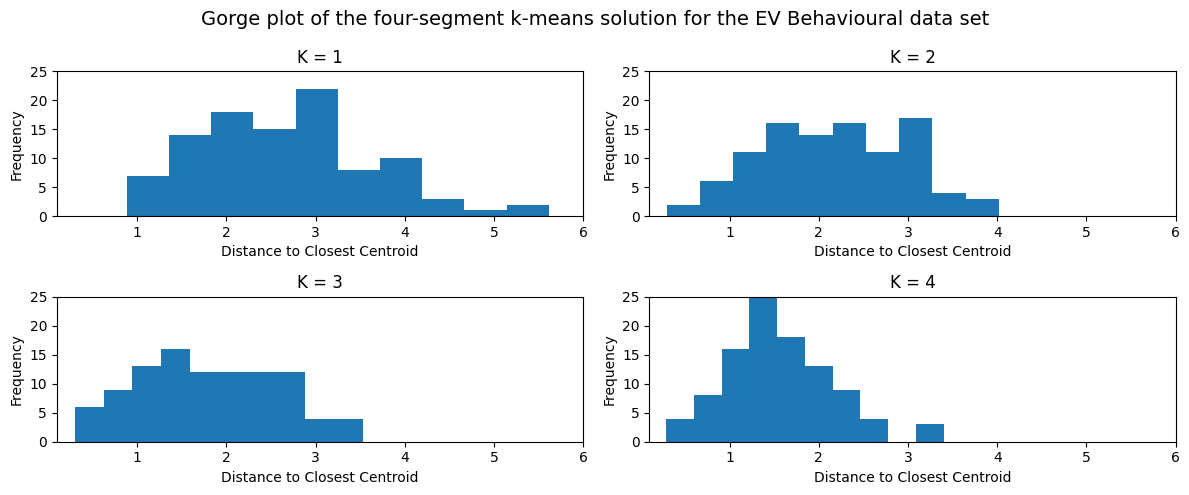

In [30]:
kmeans_data = {}
K = range(1,12)
for i in K:
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(x) # Use x from PCA transformation
    kmeans_data[str(i)] = kmeans

fig, axs = plt.subplots(2, 2, figsize=(12, 5))
for i in range(1, 5):
    similarities = kmeans_data[str(i)].transform(x).min(axis=1)
    row = (i - 1) // 2
    col = (i - 1) % 2
    axs[row, col].hist(similarities, bins=10)
    axs[row, col].set_xlim(0.1, 6)
    axs[row, col].set_ylim(0, 25)
    axs[row, col].set_title(f'K = {i}')
    axs[row, col].set_xlabel('Distance to Closest Centroid')
    axs[row, col].set_ylabel('Frequency')
fig.suptitle("Gorge plot of the four-segment k-means solution for the EV Behavioural data set", size=14)
plt.tight_layout()
plt.show()


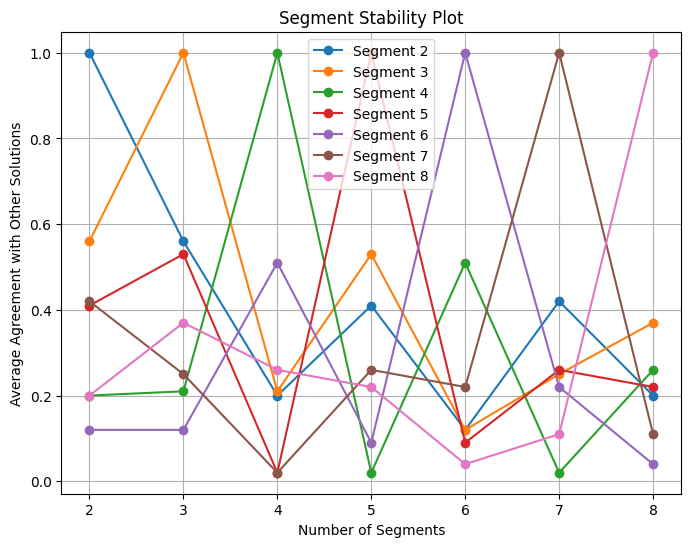

In [31]:

num_segments = range(2, 9)
segment_stability = []
for segment in range(2, 9):
    labels_segment = kmeans_data[str(segment)].predict(x) # Use x from PCA transformation
    segment_stability.append(labels_segment)

plt.figure(figsize=(8, 6))
for i, segment in enumerate(range(2, 9)):
    plt.plot(num_segments, [np.mean(segment_stability[i] == labels) for labels in segment_stability], marker='o', label=f'Segment {segment}')
plt.xlabel('Number of Segments')
plt.ylabel('Average Agreement with Other Solutions')
plt.title('Segment Stability Plot')
plt.legend()
plt.grid(True)
plt.show()


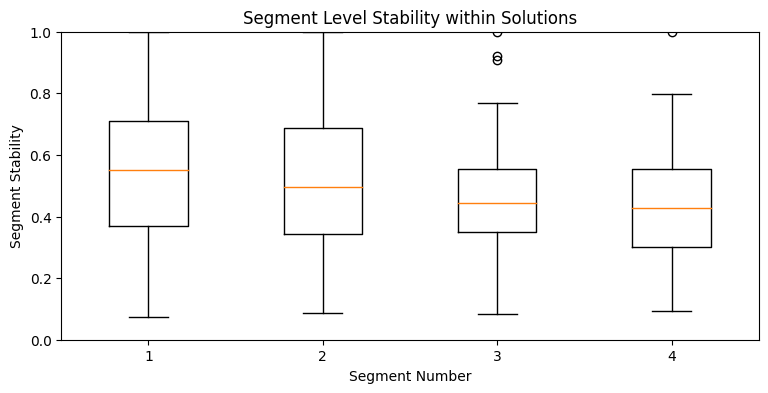

In [32]:

segment_labels = {}
segment_similarities = {}

for i in range(2,6):
    segment_labels[str(i)] = kmeans_data[str(i)].predict(x)
    segment_similarities[str(i)] = kmeans_data[str(i)].transform(x).min(axis=1)

segment_stability_values = []
for i in range(2,6):
    similarities = segment_similarities[str(i)]
    normalized_similarities = similarities / np.max(similarities)
    segment_stability_values.append(normalized_similarities)


plt.figure(figsize=(9,4))
plt.boxplot(segment_stability_values, whis=1.5)
plt.xlabel("Segment Number")
plt.ylabel("Segment Stability")
plt.xticks(range(1, 5))
plt.ylim(0, 1)
plt.title("Segment Level Stability within Solutions")
plt.show()

# Using Mixtures of Distributions

In [33]:
from scipy.stats import entropy

np.random.seed(1234)
k_values = range(2, 9)
MD_m28 = []

for k in k_values:
    model = KMeans(n_clusters=k, random_state=1234, n_init='auto')
    model.fit(df_scaled.values)
    iter_val = model.n_iter_
    converged = True
    k_val = k
    k0_val = k
    log_likelihood = -model.inertia_
    n_samples, _ = df_scaled.shape
    aic = -2 * log_likelihood + 2 * k
    bic = -2 * log_likelihood + np.log(n_samples) * k
    labels = model.labels_
    counts = np.bincount(labels)
    probs = counts / float(counts.sum())
    class_entropy = entropy(probs)
    icl = bic - class_entropy

    MD_m28.append((iter_val, converged, k_val, k0_val, log_likelihood, aic, bic, icl))
MD_m28 = pd.DataFrame(MD_m28, columns=['iter', 'converged', 'k', 'k0', 'logLik', 'AIC', 'BIC', 'ICL'])

print(MD_m28)

   iter  converged  k  k0      logLik          AIC          BIC          ICL
0     7       True  2   2 -886.036690  1776.073380  1781.283720  1780.597790
1     5       True  3   3 -622.421663  1250.843326  1258.658837  1257.587563
2     3       True  4   4 -553.751227  1115.502455  1125.923136  1124.585523
3     5       True  5   5 -498.974929  1007.949858  1020.975709  1019.472267
4     7       True  6   6 -443.536078   899.072157   914.703178   912.999614
5     4       True  7   7 -399.693640   813.387281   831.623472   829.763480
6     5       True  8   8 -361.966859   739.933718   760.775079   758.768674


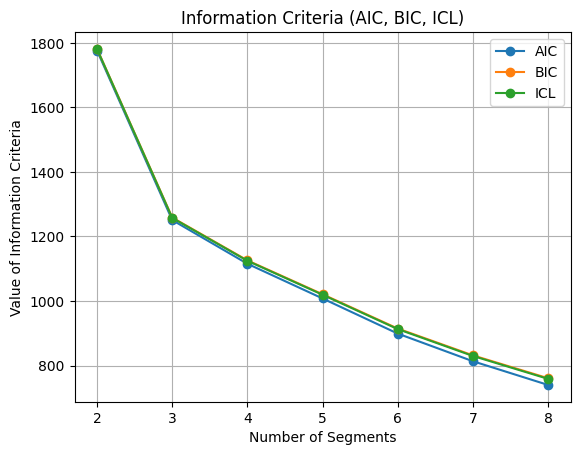

In [34]:
num_segments = MD_m28["k"]
AIC_values = MD_m28["AIC"]
BIC_values = MD_m28["BIC"]
ICL_values = MD_m28["ICL"]

plt.plot(num_segments, AIC_values, marker='o', label='AIC')
plt.plot(num_segments, BIC_values, marker='o', label='BIC')
plt.plot(num_segments, ICL_values, marker='o', label='ICL')
plt.xlabel('Number of Segments')
plt.ylabel('Value of Information Criteria')
plt.title('Information Criteria (AIC, BIC, ICL)')
plt.legend()
plt.grid(True)
plt.show()

In [35]:

from sklearn.mixture import GaussianMixture


# Contingency Table
kmeans = KMeans(n_clusters=4, random_state=1234, n_init='auto')
kmeans.fit(df_scaled)
kmeans_clusters = kmeans.predict(df_scaled)

gmm = GaussianMixture(n_components=4, random_state=1234)
gmm.fit(df_scaled)
gmm_clusters = gmm.predict(df_scaled)

results = pd.DataFrame({'kmeans': kmeans_clusters, 'mixture': gmm_clusters})

print("Contingency Table:")
contingency_table = pd.crosstab(results['kmeans'], results['mixture'])
contingency_table

Contingency Table:


mixture,0,1,2,3
kmeans,,,,
0,32,0,0,0
1,0,24,0,1
2,9,0,21,0
3,0,0,0,13


# Profiling Segments

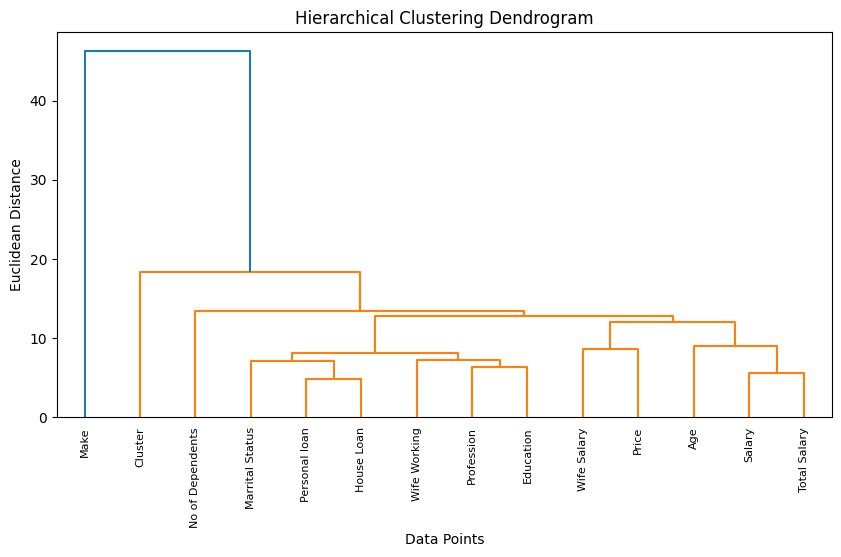

In [36]:

from scipy.cluster.hierarchy import linkage, dendrogram

# Perform hierarchical clustering
MD_vclust = linkage(df_scaled.transpose(), method='complete')

# Create a dendrogram to visualize the hierarchical clustering
plt.figure(figsize=(10, 5))
dendrogram(MD_vclust, labels=df_scaled.columns, leaf_rotation=90, leaf_font_size=8)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel("Data Points")
plt.ylabel("Euclidean Distance")
plt.show()

In [37]:
data_pivot = df_encoded.groupby('Cluster').mean().T
data_pivot_mean = data_pivot.mean(axis=1).reset_index()
data_pivot_mean.columns = ['Variable', 'Value']


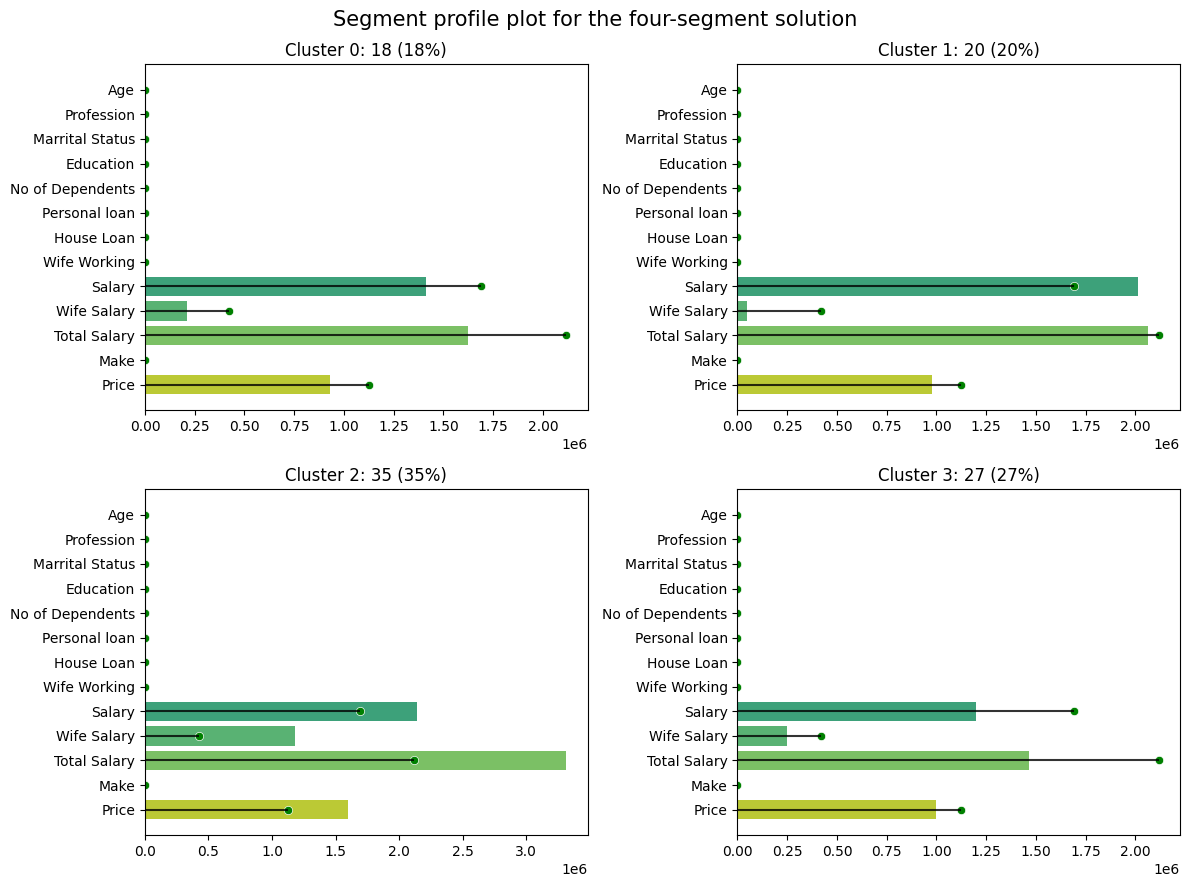

In [38]:
# Segment profile plot for the four-segment
plt.figure(figsize = (12, 9))
for i in range(4):
    plt.subplot(2, 2, i+1)
    sns.barplot(data_pivot, x = i, y = data_pivot.index, palette='viridis')
    sns.scatterplot(data_pivot_mean, x = 'Value', y = 'Variable', color = 'green')
    for index, row in data_pivot_mean.iterrows():
        plt.hlines(y=row['Variable'], xmin=0, xmax=row['Value'], colors='black', alpha = 0.8)
    plt.ylabel("")
    plt.xlabel("")
    plt.title(f"Cluster {i}: {df_encoded['Cluster'].value_counts()[i]} ({df_encoded['Cluster'].value_counts()[i]*100/len(df_encoded):.0f}%)")

plt.suptitle("Segment profile plot for the four-segment solution", fontsize = 15)
plt.tight_layout()
plt.show()

This section presents a comprehensive analysis of the consumer segments based on their mean characteristics, as detailed in the provided data. The following insights capture the unique profiles of each segment:

**Segment 0** (18% of consumers) is characterized by its higher average values in salary, total salary, and make, indicating a more affluent group. They show a strong emphasis on having a wife working and higher personal and house loans. This segment values education and has relatively fewer dependents compared to others, suggesting a more financially stable and educated demographic.

**Segment 1** (20% of consumers) features a moderate average salary and total salary, with a notable increase in personal and house loans. This group has a higher number of dependents and shows less emphasis on education compared to Segment 0. Their lower "Make" value suggests less focus on vehicle brand or prestige.

**Segment 2** (35% of consumers) stands out with higher values in salary, total salary, and make, similar to Segment 0 but with a notable difference in marital status. This group has fewer dependents and a moderate level of personal and house loans. They also show a higher appreciation for the vehicle's make and price, indicating a preference for value and prestige.

**Segment 3** (27% of consumers) has the lowest average salary and total salary, with minimal house loans and personal loans. They also exhibit fewer dependents and a moderate level of wife working status. This segment is characterized by its relatively high value placed on marital status and personal loan, indicating a different set of priorities compared to other segments.

In summary, each segment reflects distinct financial profiles and priorities, with varying emphasis on salary, dependents, loans, and vehicle make. This segmentation helps in tailoring marketing strategies to address the specific needs and preferences of each group.

In [39]:
# Separate numerical and categorical columns
numerical_columns = ['Age', 'No of Dependents', 'Salary', 'Wife Salary', 'Total Salary', 'Price']
categorical_columns = ['Profession', 'Marrital Status', 'Education', 'Personal loan', 'House Loan', 'Wife Working', 'Make']

# Profiling numerical features
numerical_profile = data.groupby('Cluster')[numerical_columns].median()
numerical_profile['Size'] = data['Cluster'].value_counts()

# Profiling categorical features
categorical_profile = pd.DataFrame()
for col in categorical_columns:
    mode_series = data.groupby('Cluster')[col].agg(lambda x: x.mode()[0])
    categorical_profile[col] = mode_series

# Combine numerical and categorical profiles
segment_profile = pd.concat([numerical_profile, categorical_profile], axis=1)
segment_profile

,Age,No of Dependents,Salary,Wife Salary,Total Salary,Price,Size,Profession,Marrital Status,Education,Personal loan,House Loan,Wife Working,Make
Cluster,,,,,,,,,,,,,,
0,32.5,2.0,1400000.0,0.0,1650000.0,800000.0,18,Business,Married,Post Graduate,No,No,No,i20
1,41.5,3.0,2050000.0,0.0,2050000.0,1050000.0,20,Salaried,Married,Graduate,Yes,Yes,No,Baleno
2,37.0,3.0,2000000.0,1100000.0,3100000.0,1600000.0,35,Salaried,Married,Post Graduate,No,No,Yes,SUV
3,31.0,0.0,1300000.0,0.0,1400000.0,1100000.0,27,Salaried,Married,Post Graduate,No,No,No,Baleno
